name                                      avg_abs (%)       max (%)     min (%)      avg (%)    std (%)
--------------------------------------  -------------  ------------  ----------  -----------  ---------
Naive (k0=0)                                0.681827   -2.98272e-05  -1.214      -0.681827    0.35881
Original Quake                              0.0950925  -6.46654e-06  -0.174958   -0.0950925   0.0570967
Gradient descent single parameter           0.0584816   0            -0.281914   -0.0584816   0.0714724
Jan Kadlec                                  0.0421109   0.0650164    -0.0650132   0.0201531   0.0424343
Gradient descent with three parameters      0.0268434   0.0472253    -0.144237   -0.00582846  0.0379856


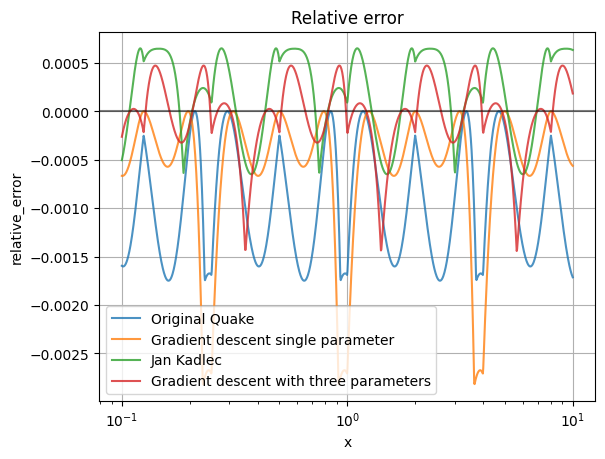

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def quick_invsqrt_quake(x, k0):
    Qx = np.frombuffer(x, dtype=np.int32)
    Qy = k0 - (Qx >> 1)
    y0 = np.frombuffer(Qy, dtype=np.float32)
    y1 = y0*(1.5 - 0.5*x*y0*y0)
    return y1

def quick_invsqrt_jan_kadlec(x, k):
    Qx = np.frombuffer(x, dtype=np.int32)
    Qy = k[0] - (Qx >> 1)
    y0 = np.frombuffer(Qy, dtype=np.float32)
    y1 = y0*(k[1]*x*y0*y0 + k[2])
    return y1

x = np.logspace(-1,1,1200)
y_target = 1.0/np.sqrt(x)
x = x.astype(np.float32)
y_target = y_target.astype(np.float32)

benchmarks = [
    ("Naive (k0=0)", lambda x: quick_invsqrt_quake(x, 381<<22)),
    ("Original Quake", lambda x: quick_invsqrt_quake(x, 0x5F3759DF)),
    ("Gradient descent single parameter", lambda x: quick_invsqrt_quake(x, 1597311293)),
    ("Jan Kadlec", lambda x: quick_invsqrt_jan_kadlec(x, [0x5F1FFFF9, -0.703952253, 0.703952253*2.38924456])),
    ("Gradient descent with three parameters", lambda x: quick_invsqrt_jan_kadlec(x, [1591369693, -2.13550628, 2.43447248])),
]

N = len(benchmarks)
y_pred = [None]*N
y_error_rel = [None]*N
y_table = [None]*N

for i in range(N):
    (name, func) = benchmarks[i]
    y_pred[i] = func(x)
    y_error_rel[i] = (y_pred[i] - y_target) / y_target
    e = y_error_rel[i]
    e_abs_avg = np.mean(np.abs(e))
    e_max = np.max(e)
    e_min = np.min(e)
    e_avg = np.mean(e)
    e_std = np.std(e)
    y_table[i] = [name, e_abs_avg*1e2, e_max*1e2, e_min*1e2, e_avg*1e2, e_std*1e2]
print(tabulate(y_table, headers=["name", "avg_abs (%)", "max (%)", "min (%)", "avg (%)", "std (%)"]))

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(N):
    if i == 0:
        # ignore naive results, they are not worth comparing
        continue
    name, _ = benchmarks[i]
    ax.plot(x, y_error_rel[i], label=f"{name}", alpha=0.8 if i > 0 else 1.0)
ax.axhline(0, color="black", alpha=0.5)
ax.set_xscale("log")
ax.set_xlabel("x")
ax.set_ylabel("relative_error")
ax.set_title("Relative error")
ax.grid(True)
_ = ax.legend()